# 0. Imports and inputs

In [1]:
# import the library
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import calendar
import numpy as np
import matplotlib.dates as mdates
import sys
import os
from os import listdir
from os.path import isfile, join
from dateutil import parser
import re
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import (GradientBoostingRegressor, 
                              RandomForestRegressor, 
                              AdaBoostRegressor, 
                              BaggingRegressor, 
                              ExtraTreesRegressor,
                              HistGradientBoostingRegressor,
                              StackingRegressor,
                              VotingRegressor)
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import seaborn as sns
import matplotlib.colors as mcolors
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
from datetime import datetime, timedelta
from matplotlib import animation
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.impute import SimpleImputer
# from func_defs import *

# %matplotlib ipympl
%matplotlib inline


# define the inverter to analyse
inverter = '2-1'

# define the plot template
axis_label_size = 15
axis_num_size = 12
text_size = 12
title_size = 22

# define the figure size for single plot
figure_size = (6, 6)
subplot_size_1_2 = (6, 6)
long_hoz_figsize = (12, 6)

# define the file directory for SunSolve data
sunsolve_dir = r"C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\25_09_02_Bomen_bifacial_gain_2021\Data\SunSolve Yield\Per inverter\2-1\0_mimic_PVsyst\25_09_10_Bomen_2021_1.csv"
# define the file directory for PVsyst data
pvsyst_dir = r"C:\Users\z5183876\PVsyst8.0_Data\UserHourly\25_08_25_Bowen Solar Farm 2021_VC1_HourlyRes_0.CSV"

# 1. Data loading 

## 1.1. SunSolve Yield data loading

In [2]:
# Load the SunSolve yield data as csv file
sunsolve_df = pd.read_csv(sunsolve_dir)

# Print the columns of the SunSolve df
# print("Columns in SunSolve data:")
print(sunsolve_df.columns)

# Create a timestamp column from the Day of year, Hour, and Minute columns
# First, we need to determine the year (assuming 2021 from your file naming)
year = 2021

# Create a timestamp using a different approach - convert day of year to date
# This creates a base date for the year and adds the day of year as timedelta
base_date = pd.Timestamp(f"{year}-01-01")  # January 1st of the specified year
sunsolve_df['Timestamp'] = sunsolve_df.apply(
    lambda row: base_date + pd.Timedelta(days=int(row['Day of year'])-1) + 
                pd.Timedelta(hours=int(row['Hour'])) + 
                pd.Timedelta(minutes=int(row['Minute'])),
    axis=1
)

# print("Created timestamp column.")
# print(sunsolve_df['Timestamp'].head())

# Define a scaling factor for the SunSolve df power
sunsolve_scaling_1 = 1e-3

# Convert power from W to MW
sunsolve_df['Inverter power (MW)'] = sunsolve_df['Power [unit-system] (W)'] * sunsolve_scaling_1

# Set the timestamp as the index for easier resampling
sunsolve_df.set_index('Timestamp', inplace=True)

# Now resample to daily data using the index
# For hourly data converted to daily energy, we need to multiply by the time period
# The 'Period (h)' column contains the duration of each data point in hours
sunsolve_df['Hourly energy (MWh)'] = sunsolve_df['Inverter power (MW)'] * sunsolve_df['Period (h)']

# Identify all columns containing "(W)" - these are power measurements
power_columns = [col for col in sunsolve_df.columns if "(W)" in col]

# Create energy columns for each power column
for col in power_columns:
    # Create a new column name by replacing "(W)" with "(Wh)"
    energy_col_name = col.replace("(W)", "(Wh)")
    
    # Convert power to energy by multiplying by the time period
    sunsolve_df[energy_col_name] = sunsolve_df[col] * sunsolve_df['Period (h)']

# Resample all energy columns to daily totals
daily_energy_df = sunsolve_df[[col for col in sunsolve_df.columns if "(Wh)" in col]].resample('D').sum()

# Convert from Wh to MWh for consistency with your other calculations
for col in daily_energy_df.columns:
    daily_energy_df[col] = daily_energy_df[col] * 1e-6  # Convert Wh to MWh
    new_col_name = col.replace("(Wh)", "(MWh/day)")
    daily_energy_df.rename(columns={col: new_col_name}, inplace=True)

# Display the results
print("Daily energy values from power measurements:")
print(daily_energy_df.head())

# Initialize sunsolve_daily with the hourly energy resampled to daily
sunsolve_daily = sunsolve_df['Hourly energy (MWh)'].resample('D').sum().to_frame(name='Inverter energy (MWh/day)')

# Merge with the other energy columns
sunsolve_daily = pd.concat([sunsolve_daily, daily_energy_df], axis=1)

# print hte columns of hte sunsolve_daily
print("Columns in daily resampled SunSolve data:")
print(sunsolve_daily.columns)

Index(['Day of year', 'Hour', 'Minute', 'Period (h)', 'Flag', 'Message',
       'Solar zenith (degrees)', 'Solar elevation (degrees)',
       'Solar azimuth (degrees)', 'GHI (W/m2)', 'DHI (W/m2)', 'DNI (W/m2)',
       'Diffuse fraction', 'Ambient temperature (°C)', 'Wind velocity (m/s)',
       'Wind direction', 'Opaque cloud fraction', 'Air mass',
       'Precipitable water vapour (cm)', 'Ozone (atm.cm)',
       'Aerosol optical density', 'Relative humidity (%)',
       'Far field albedo (%)', 'Surface pressure (mb)',
       'Module tilt (degrees)', 'Incident angle (degrees)',
       'VF power for Tmod [average] (W/m2)',
       'VF power for Tmod front [average] (W/m2)',
       'VF power for Tmod rear [average] (W/m2)',
       'Module temperature [average] (C)',
       'Power - no mismatch @25C [unit-system] (W)',
       'Power - no mismatch [unit-system] (W)', 'Power [unit-system] (W)',
       'Vmp [average] (V)', 'Imp [average] (A)', 'Imp [minimum] (A)',
       'Voc [average] (V)', 

## 1.2. PVsyst data loading

In [3]:
# read the csv file
PVsyst_results_df = pd.read_csv(
    pvsyst_dir,
    delimiter=';',
    skiprows=list(range(10)) + [11],  # Skip metadata (0-9) and units row (11)
    header=0,  # Row 10 becomes the header after skipping
    encoding='latin-1',  # Keep the encoding that worked
    low_memory=False,
    na_values=['', ' ', 'nan', 'NaN']
)

# Convert to datetime using the correct format with 2-digit year (%y instead of %Y)
PVsyst_results_df['date'] = pd.to_datetime(PVsyst_results_df['date'], format='%d/%m/%y %H:%M')


# Set the timestamp as the index for easier plotting
PVsyst_results_df.set_index('date', inplace=True)

# resample to daily energy by summing up the hourly energy values
PVsyst_daily = PVsyst_results_df['EArray'].resample('D').sum().to_frame(name='PVsyst energy (MWh/day)')

# 2. Data comparison

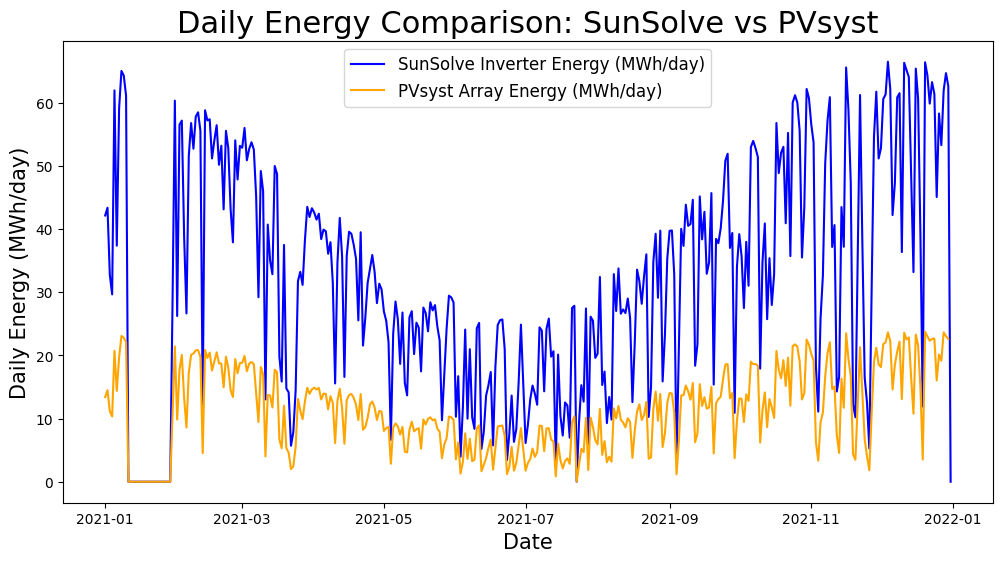

CRMSE: 24.0415 MWh/day
RMSE: 24.0415 MWh/day
MBE: 20.9952 MWh/day
NRMSE: 1.0119


In [4]:
# plot the daily energy from both datasets for comparison
plt.figure(figsize=long_hoz_figsize)
plt.plot(sunsolve_daily.index, sunsolve_daily['Inverter energy (MWh/day)'], label='SunSolve Inverter Energy (MWh/day)', color='blue')
plt.plot(PVsyst_daily.index, PVsyst_daily['PVsyst energy (MWh/day)'], label='PVsyst Array Energy (MWh/day)', color='orange')
plt.xlabel('Date', fontsize=axis_label_size)
plt.ylabel('Daily Energy (MWh/day)', fontsize=axis_label_size)
plt.title('Daily Energy Comparison: SunSolve vs PVsyst', fontsize=title_size)
plt.legend(fontsize=text_size)
plt.show()

# calculate hte evaluation matrix: CRMSE, RMSE, MBE, NRMSE, then print
merged_daily = pd.merge(sunsolve_daily, PVsyst_daily, left_index=True, right_index=True, how='inner')
merged_daily.dropna(inplace=True)  # Drop rows with NaN values
crmse = np.sqrt(mean_squared_error(merged_daily['PVsyst energy (MWh/day)'], merged_daily['Inverter energy (MWh/day)']))
rmse = np.sqrt(mean_squared_error(merged_daily['PVsyst energy (MWh/day)'], merged_daily['Inverter energy (MWh/day)']))
mbe = np.mean(merged_daily['Inverter energy (MWh/day)'] - merged_daily['PVsyst energy (MWh/day)'])
nrmse = rmse / (merged_daily['PVsyst energy (MWh/day)'].max() - merged_daily['PVsyst energy (MWh/day)'].min())
print(f"CRMSE: {crmse:.4f} MWh/day")
print(f"RMSE: {rmse:.4f} MWh/day")
print(f"MBE: {mbe:.4f} MWh/day")
print(f"NRMSE: {nrmse:.4f}")


# 3. Optimisation

=== OPTIMIZING SUNSOLVE SCALING FACTOR ===
Target MBE tolerance: 1e-13 MWh/day
         Press Ctrl+C to interrupt if the search takes too long.

Starting binary search for optimal scaling factor...
Initial search range: [0.0010000000, 0.1000000000]
Initial MBE: -1.1296240785e+01
Iteration 1: Factor = 0.0505000000, MBE = -1.1294642355e+01
Iteration 2: Factor = 0.0752500000, MBE = -1.1293843140e+01
Iteration 3: Factor = 0.0876250000, MBE = -1.1293443533e+01
Iteration 4: Factor = 0.0938125000, MBE = -1.1293243729e+01
Iteration 5: Factor = 0.0969062500, MBE = -1.1293143827e+01
Iteration 6: Factor = 0.0984531250, MBE = -1.1293093876e+01
Iteration 7: Factor = 0.0992265625, MBE = -1.1293068901e+01
Iteration 8: Factor = 0.0996132813, MBE = -1.1293056413e+01
Iteration 9: Factor = 0.0998066406, MBE = -1.1293050169e+01
Iteration 10: Factor = 0.0999033203, MBE = -1.1293047047e+01
Iteration 20: Factor = 0.0999999056, MBE = -1.1293043928e+01
Iteration 30: Factor = 0.0999999999, MBE = -1.1293043925e+

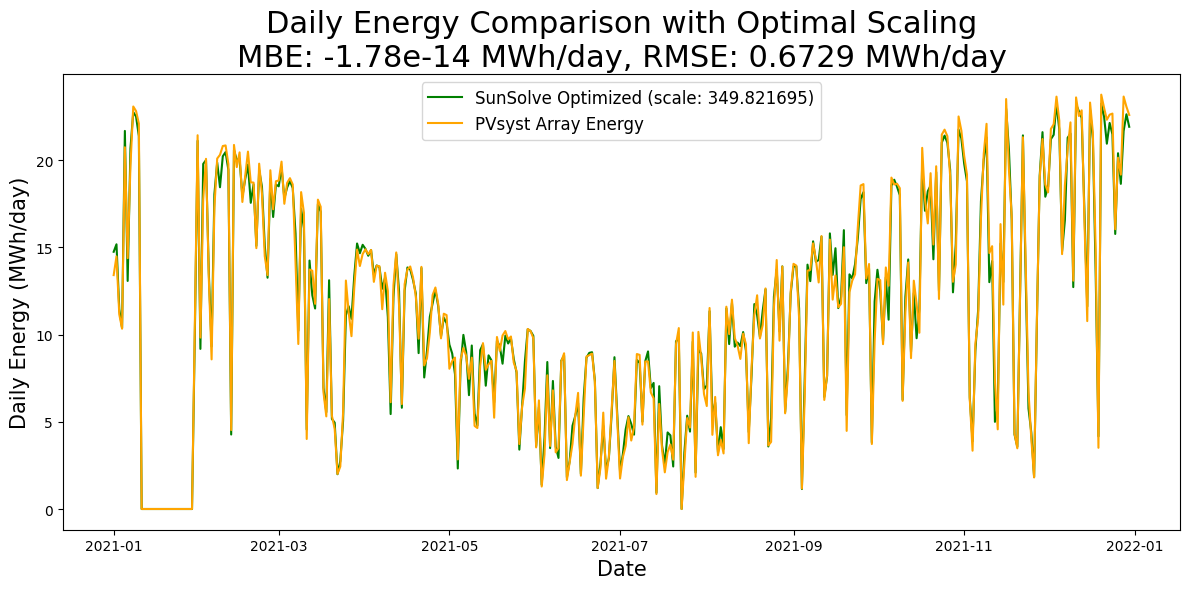

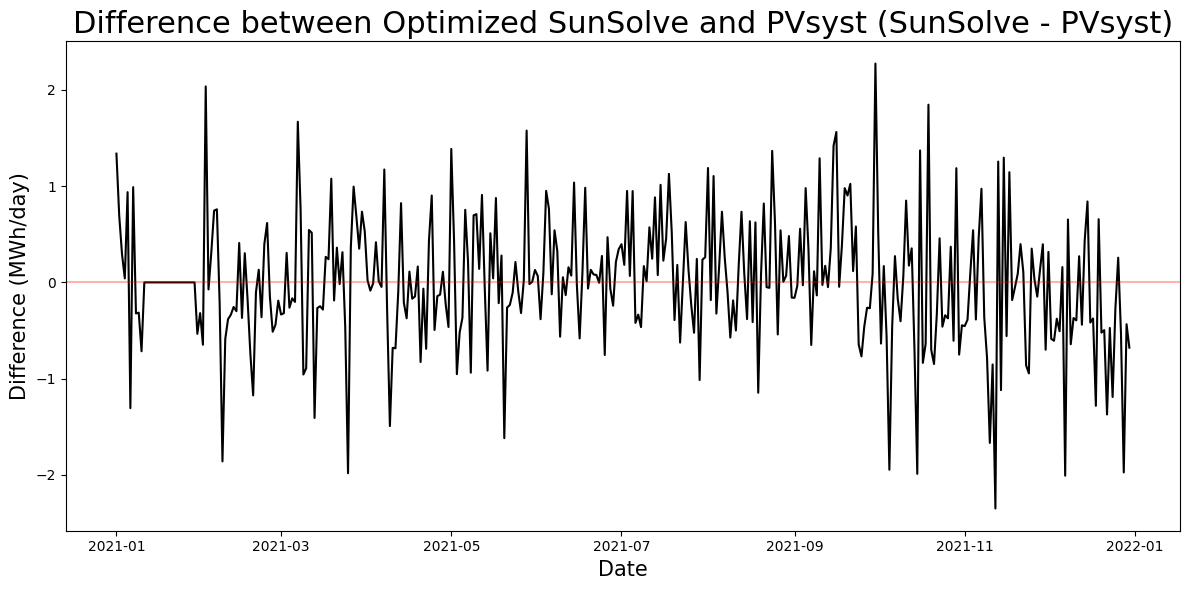

In [5]:
# Cell to optimize SunSolve scaling factor to minimize MBE
print("=== OPTIMIZING SUNSOLVE SCALING FACTOR ===")
print("Target MBE tolerance: 1e-13 MWh/day")
print("WARNING: Running with unlimited iterations and no factor boundaries.")
print("         Press Ctrl+C to interrupt if the search takes too long.")

# Function to calculate MBE for a given scale factor
def calculate_mbe(scale_factor):
    """Calculate Mean Bias Error for given scale factor applied to SunSolve data"""
    # Create temporary daily energy with the scaling factor applied
    temp_sunsolve_daily = sunsolve_df['Power [unit-system] (W)'] * scale_factor * sunsolve_df['Period (h)'] * 1e-6
    temp_sunsolve_daily = temp_sunsolve_daily.resample('D').sum().to_frame(name='Scaled Inverter energy (MWh/day)')
    
    # Merge with PVsyst data
    temp_merged = pd.merge(temp_sunsolve_daily, PVsyst_daily, left_index=True, right_index=True, how='inner')
    temp_merged.dropna(inplace=True)
    
    # Calculate MBE
    return np.mean(temp_merged['Scaled Inverter energy (MWh/day)'] - temp_merged['PVsyst energy (MWh/day)'])

# Determine a reasonable starting range based on current MBE
initial_mbe = calculate_mbe(sunsolve_scaling_1)
if initial_mbe > 0:
    # SunSolve > PVsyst, so we need to reduce the factor
    min_factor = sunsolve_scaling_1 * 0.01  # Start with 1% of current factor
    max_factor = sunsolve_scaling_1
else:
    # SunSolve < PVsyst, so we need to increase the factor
    min_factor = sunsolve_scaling_1
    max_factor = sunsolve_scaling_1 * 100  # Try up to 100x current factor

# Binary search to find optimal scaling factor with no limits
def find_optimal_scaling_factor(min_factor=min_factor, max_factor=max_factor):
    print("\nStarting binary search for optimal scaling factor...")
    print(f"Initial search range: [{min_factor:.10f}, {max_factor:.10f}]")
    print(f"Initial MBE: {calculate_mbe(sunsolve_scaling_1):.10e}")
    
    iterations = 0
    best_factor = None
    best_mbe = float('inf')
    
    # Continue until precision tolerance is met (no iteration limit)
    while True:
        iterations += 1
        mid_factor = (min_factor + max_factor) / 2
        
        # Calculate MBE for the current factor
        mbe = calculate_mbe(mid_factor)
        
        # Track the best factor found
        if abs(mbe) < abs(best_mbe):
            best_factor = mid_factor
            best_mbe = mbe
        
        # Print status every 10 iterations to show progress
        if iterations % 10 == 0 or iterations < 10:
            print(f"Iteration {iterations}: Factor = {mid_factor:.10f}, MBE = {mbe:.10e}")
        
        # Check if we've reached the target precision
        if abs(mbe) < 1e-13:
            print(f"✓ Converged! Found factor with MBE below tolerance.")
            return mid_factor, mbe, iterations
        
        # Adjust search range based on MBE sign
        if mbe > 0:  # MBE is positive (SunSolve > PVsyst), need to decrease factor
            max_factor = mid_factor
        else:  # MBE is negative (SunSolve < PVsyst), need to increase factor
            min_factor = mid_factor
    
            
        # Dynamically expand range if we're stuck at a boundary
        if iterations % 100 == 0:
            # Check if we're consistently hitting the lower boundary
            if abs(min_factor - mid_factor) < 1e-10:
                new_min = min_factor * 0.1  # Expand downward
                print(f"Expanding search range downward: {min_factor:.10f} -> {new_min:.10f}")
                min_factor = new_min
                
            # Check if we're consistently hitting the upper boundary
            if abs(max_factor - mid_factor) < 1e-10:
                new_max = max_factor * 10  # Expand upward
                print(f"Expanding search range upward: {max_factor:.10f} -> {new_max:.10f}")
                max_factor = new_max

# Find the optimal scaling factor
optimal_factor, final_mbe, iterations = find_optimal_scaling_factor()

print("\n=== OPTIMIZATION RESULTS ===")
print(f"Original scaling factor: {sunsolve_scaling_1:.10f}")
print(f"Optimal scaling factor: {optimal_factor:.10f}")
print(f"Final MBE: {final_mbe:.12e} MWh/day")
print(f"Found in {iterations} iterations")

# Apply the optimal scaling factor to create optimally scaled data
print("\n=== APPLYING OPTIMAL SCALING FACTOR ===")
# Create optimally scaled daily energy
sunsolve_daily_optimized = sunsolve_df['Power [unit-system] (W)'] * optimal_factor * sunsolve_df['Period (h)'] * 1e-6
sunsolve_daily_optimized = sunsolve_daily_optimized.resample('D').sum().to_frame(name='Optimized Inverter energy (MWh/day)')

# Merge the optimized data with PVsyst for metrics calculation
merged_optimized = pd.merge(sunsolve_daily_optimized, PVsyst_daily, left_index=True, right_index=True, how='inner')
merged_optimized.dropna(inplace=True)

# Calculate metrics with optimal scaling
optimized_rmse = np.sqrt(mean_squared_error(merged_optimized['PVsyst energy (MWh/day)'], 
                                           merged_optimized['Optimized Inverter energy (MWh/day)']))
optimized_mbe = np.mean(merged_optimized['Optimized Inverter energy (MWh/day)'] - merged_optimized['PVsyst energy (MWh/day)'])
optimized_nrmse = optimized_rmse / (merged_optimized['PVsyst energy (MWh/day)'].max() - merged_optimized['PVsyst energy (MWh/day)'].min())

print("\n=== METRICS WITH OPTIMAL SCALING ===")
print(f"RMSE: {optimized_rmse:.4f} MWh/day")
print(f"MBE: {optimized_mbe:.4e} MWh/day")
print(f"NRMSE: {optimized_nrmse:.4f}")

# Plot comparison of original, optimized and PVsyst data
plt.figure(figsize=long_hoz_figsize)
# plt.plot(merged_daily.index, merged_daily['Inverter energy (MWh/day)'], 
#          label=f'SunSolve Original (scale: {sunsolve_scaling_1:.6f})', color='blue', alpha=0.5)
plt.plot(merged_optimized.index, merged_optimized['Optimized Inverter energy (MWh/day)'], 
         label=f'SunSolve Optimized (scale: {optimal_factor:.6f})', color='green')
plt.plot(merged_optimized.index, merged_optimized['PVsyst energy (MWh/day)'], 
         label='PVsyst Array Energy', color='orange')

plt.xlabel('Date', fontsize=axis_label_size)
plt.ylabel('Daily Energy (MWh/day)', fontsize=axis_label_size)
plt.title(f'Daily Energy Comparison with Optimal Scaling\nMBE: {optimized_mbe:.2e} MWh/day, RMSE: {optimized_rmse:.4f} MWh/day', 
          fontsize=title_size)
plt.legend(fontsize=text_size)
plt.tight_layout()
plt.show()

# Create a difference plot
plt.figure(figsize=long_hoz_figsize)
plt.plot(merged_optimized.index, 
         merged_optimized['Optimized Inverter energy (MWh/day)'] - merged_optimized['PVsyst energy (MWh/day)'],
         color='black')
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.xlabel('Date', fontsize=axis_label_size)
plt.ylabel('Difference (MWh/day)', fontsize=axis_label_size)
plt.title('Difference between Optimized SunSolve and PVsyst (SunSolve - PVsyst)', fontsize=title_size)
plt.tight_layout()
plt.show()